In [29]:
import os, sys
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from datetime import datetime
from math import sqrt

base_path = os.getcwd().split('college_basketball')[0]  + 'college_basketball/'
sys.path.append(base_path+'/src')
from ClusterTeams import ClusterFeatures
clusterEngine = ClusterFeatures()


In [30]:
training_version = 2.12022
targetCol = 'score'

In [31]:
base_path = os.getcwd().split('college_basketball')[0]  + 'college_basketball/'
modelDir = base_path + '/models/'
dataDir = base_path + '/data/'

In [32]:
# Load Raw Training Data
raw = pd.read_csv(dataDir+'/processed/trainingData/teamLevelTrainingData.csv')
print(raw.shape)
raw.head()

(2750, 171)


team_name  score        date  rank homeAway  top25  \
0               purdue   96.0  01-17-2022   4.0     away      0   
1              belmont   80.0  01-17-2022   NaN     away      0   
2      bethune cookman   63.0  01-17-2022   NaN     away      0   
3  central connecticut   66.0  01-17-2022   NaN     away      0   
4            charlotte   67.0  01-17-2022   NaN     away      0   

                                              gameID   Rk  Rk_opposition  \
0                         01-17-2022-purdue-illinois    4             12   
1  01-17-2022-belmont-southern-illinois-edwardsville   56            275   
2     01-17-2022-bethune-cookman-arkansas-pine-bluff  347            355   
3  01-17-2022-central-connecticut-state-sacred-heart  343            288   
4              01-17-2022-charlotte-florida-atlantic  220            161   

   Conf  ... ppg_homeaway ppg_homeway_opp threePT_homeaway  \
0   B10  ...         79.0            89.5             32.9   
1   OVC  ...         74.1            85.7             31.9   
2  SWAC  ...         58.3            60.5             22.0   
3   NEC  ...         57.8            72.8             34.6   
4  CUSA  ...         70.2            73.0             34.2   

   threePT_homeaway_opp  tempoFast  tempoSlow  tempoMismatch  \
0                  35.5          0          0              0   
1                  35.0          0          0              0   
2                  19.8          0          0              0   
3                  33.0          0          0              0   
4                  31.3          0          0              0   

   kp_rank_diff_linear_expected_points  teamCluster  oppCluster  
0                               68.084            1          14  
1                               76.102           13          10  
2                               68.084            3           3  
3                               65.690            3           2  
4                               65.538            9           9  

[5 rows x 171 columns]

In [33]:
# Remove columns where the target value is null
raw = raw[raw['score'].notnull()].copy()
print(raw.shape)

(2720, 171)


In [34]:
# Remove Non-Numeric Columns
numeric_columns = list(raw._get_numeric_data().columns)
# Define numeric columns to remove
remove_cols = ['rank', 'top25']
trainCols = [x for x in numeric_columns if x not in remove_cols]

Text(0.5, 0, 'ScoreBin')

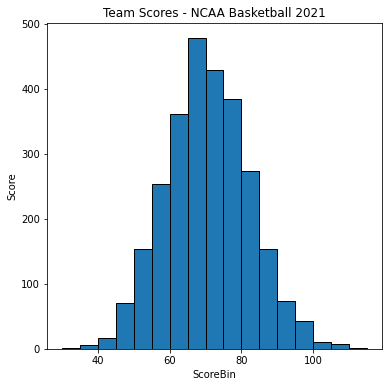

In [35]:
plt.figure(figsize=(6,6))
plt.title('Team Scores - NCAA Basketball 2021')
plt.hist(raw['score'], bins=np.arange(30,120,5), edgecolor='black')
plt.ylabel('Score')
plt.xlabel('ScoreBin')

In [36]:
scoreStats = raw['score'].describe()
raw['score'].describe()

count    2720.000000
mean       70.081985
std        11.706958
min        31.000000
25%        62.000000
50%        70.000000
75%        78.000000
max       117.000000
Name: score, dtype: float64

In [37]:
zVal = 3
outlierUpperBound = scoreStats['mean']+zVal*scoreStats['std']
print('Outlier Upper Bound: %0.2f' % outlierUpperBound)
outlierLowerBound = scoreStats['mean']-zVal*scoreStats['std']
print('Outlier Lower Bound: %0.2f' %outlierLowerBound)


beforeLen = len(raw)
raw = raw[raw['score']<=outlierUpperBound].copy()
raw = raw[raw['score']>=outlierLowerBound].copy()
afterLen = len(raw)

print('Removed %d scores as outliers' %(beforeLen-afterLen))

Outlier Upper Bound: 105.20
Outlier Lower Bound: 34.96
Removed 10 scores as outliers


Text(0.5, 0, 'Tempo Bin')

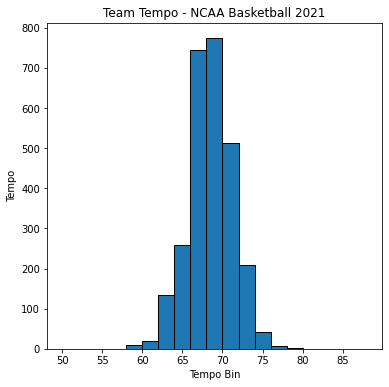

In [38]:
# Tempo Attribute
plt.figure(figsize=(6,6))
plt.title('Team Tempo - NCAA Basketball 2021')
plt.hist(raw['AdjT'], bins=np.arange(50,90,2), edgecolor='black')
plt.ylabel('Tempo')
plt.xlabel('Tempo Bin')


In [39]:
raw['AdjT'].describe()

count    2710.000000
mean       68.469963
std         2.726400
min        58.400000
25%        66.800000
50%        68.400000
75%        70.300000
max        78.000000
Name: AdjT, dtype: float64

Text(0.5, 0, 'Tempo Diff Bin')

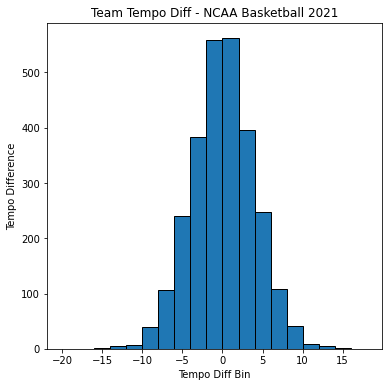

In [40]:
# Tempo Mismatch
# Tempo Attribute
plt.figure(figsize=(6,6))
plt.title('Team Tempo Diff - NCAA Basketball 2021')
plt.hist(raw['AdjT_diff'], bins=np.arange(-20,20,2), edgecolor='black')
plt.ylabel('Tempo Difference')
plt.xlabel('Tempo Diff Bin')

In [41]:
raw['AdjT_diff'].describe()

count    2710.000000
mean       -0.005351
std         3.857573
min       -14.600000
25%        -2.600000
50%         0.000000
75%         2.575000
max        14.600000
Name: AdjT_diff, dtype: float64

In [42]:
raw['kp_rank_diff'].describe()

count    2710.000000
mean        0.202583
std       115.255259
min      -351.000000
25%       -69.000000
50%         1.000000
75%        70.000000
max       351.000000
Name: kp_rank_diff, dtype: float64

Text(0.5, 0, 'Rank Difference Bin')

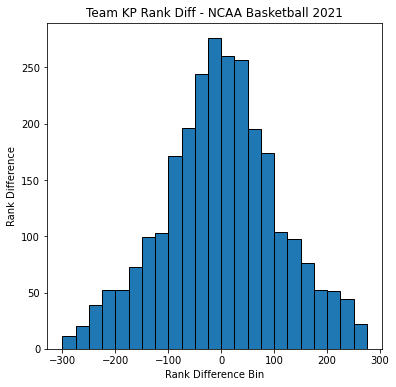

In [43]:
# KP Rank Diff - Quantify Differences in Team Ranking
plt.figure(figsize=(6,6))
plt.title('Team KP Rank Diff - NCAA Basketball 2021')
plt.hist(raw['kp_rank_diff'], bins=np.arange(-300,300,25), edgecolor='black')
plt.ylabel('Rank Difference')
plt.xlabel('Rank Difference Bin')

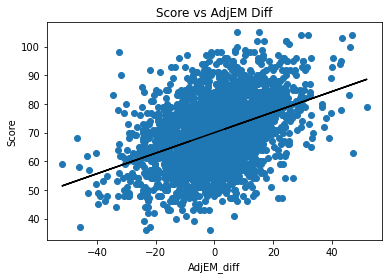

In [44]:
plt.title('Score vs AdjEM Diff')
plt.scatter(raw['AdjEM_diff'], raw['score'])
plt.xlabel('AdjEM_diff')
plt.ylabel('Score')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(raw['AdjEM_diff'], raw['score'], 1)

#add linear regression line to scatterplot 
plt.plot(raw['AdjEM_diff'], m*raw['AdjEM_diff']+b, color='black')

plt.show()

In [45]:
corr, _  = pearsonr(raw['AdjEM_diff'], raw['score'])
print(corr)

0.41161668949965124


In [46]:
print(m, b)

0.35767014571365713 70.00406792612621


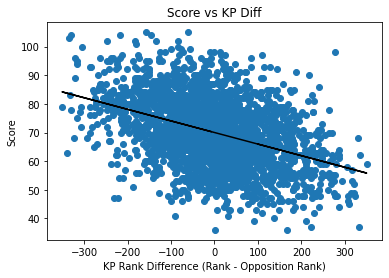

In [47]:
plt.title('Score vs KP Diff')
plt.scatter(raw['kp_rank_diff'], raw['score'])
plt.xlabel('KP Rank Difference (Rank - Opposition Rank)')
plt.ylabel('Score')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(raw['kp_rank_diff'], raw['score'], 1)

#add linear regression line to scatterplot 
plt.plot(raw['kp_rank_diff'], m*raw['kp_rank_diff']+b, color='black')

plt.show()

In [48]:
raw['kp_rank_diff'].isnull().sum()

0

In [49]:
raw['score'].isnull().sum()

0

In [50]:
corr, _  = pearsonr(raw['kp_rank_diff'], raw['score'])
print(corr)

-0.40496431209096484


In [51]:
print(m, b)

-0.04035311564903696 70.00263980091934


In [52]:
raw.head()

team_name  score        date  rank homeAway  top25  \
0               purdue   96.0  01-17-2022   4.0     away      0   
1              belmont   80.0  01-17-2022   NaN     away      0   
2      bethune cookman   63.0  01-17-2022   NaN     away      0   
3  central connecticut   66.0  01-17-2022   NaN     away      0   
4            charlotte   67.0  01-17-2022   NaN     away      0   

                                              gameID   Rk  Rk_opposition  \
0                         01-17-2022-purdue-illinois    4             12   
1  01-17-2022-belmont-southern-illinois-edwardsville   56            275   
2     01-17-2022-bethune-cookman-arkansas-pine-bluff  347            355   
3  01-17-2022-central-connecticut-state-sacred-heart  343            288   
4              01-17-2022-charlotte-florida-atlantic  220            161   

   Conf  ... ppg_homeaway ppg_homeway_opp threePT_homeaway  \
0   B10  ...         79.0            89.5             32.9   
1   OVC  ...         74.1            85.7             31.9   
2  SWAC  ...         58.3            60.5             22.0   
3   NEC  ...         57.8            72.8             34.6   
4  CUSA  ...         70.2            73.0             34.2   

   threePT_homeaway_opp  tempoFast  tempoSlow  tempoMismatch  \
0                  35.5          0          0              0   
1                  35.0          0          0              0   
2                  19.8          0          0              0   
3                  33.0          0          0              0   
4                  31.3          0          0              0   

   kp_rank_diff_linear_expected_points  teamCluster  oppCluster  
0                               68.084            1          14  
1                               76.102           13          10  
2                               68.084            3           3  
3                               65.690            3           2  
4                               65.538            9           9  

[5 rows x 171 columns]

In [53]:
# Look at affect home/away
raw.groupby('home_away')['score'].mean()

home_away
-1    67.507001
 1    72.489283
Name: score, dtype: float64

In [54]:
# Apply Cluster Features
#teamCluster = clusterEngine.clusterTeam(raw[['AdjEM', 'AdjO', 'AdjD', 'AdjT']].copy())
#raw['teamCluster'] = teamCluster
#oppCluster = clusterEngine.clusterTeam(raw[['AdjEM_opposition', 'AdjO_opposition', 'AdjD_opposition', 'AdjT_opposition']].copy())
#raw['oppCluster'] = oppCluster

#trainCols.append('teamCluster')
#trainCols.append('oppCluster')


In [55]:
trainAll = raw.copy()

In [56]:
trainAll.head()

team_name  score        date  rank homeAway  top25  \
0               purdue   96.0  01-17-2022   4.0     away      0   
1              belmont   80.0  01-17-2022   NaN     away      0   
2      bethune cookman   63.0  01-17-2022   NaN     away      0   
3  central connecticut   66.0  01-17-2022   NaN     away      0   
4            charlotte   67.0  01-17-2022   NaN     away      0   

                                              gameID   Rk  Rk_opposition  \
0                         01-17-2022-purdue-illinois    4             12   
1  01-17-2022-belmont-southern-illinois-edwardsville   56            275   
2     01-17-2022-bethune-cookman-arkansas-pine-bluff  347            355   
3  01-17-2022-central-connecticut-state-sacred-heart  343            288   
4              01-17-2022-charlotte-florida-atlantic  220            161   

   Conf  ... ppg_homeaway ppg_homeway_opp threePT_homeaway  \
0   B10  ...         79.0            89.5             32.9   
1   OVC  ...         74.1            85.7             31.9   
2  SWAC  ...         58.3            60.5             22.0   
3   NEC  ...         57.8            72.8             34.6   
4  CUSA  ...         70.2            73.0             34.2   

   threePT_homeaway_opp  tempoFast  tempoSlow  tempoMismatch  \
0                  35.5          0          0              0   
1                  35.0          0          0              0   
2                  19.8          0          0              0   
3                  33.0          0          0              0   
4                  31.3          0          0              0   

   kp_rank_diff_linear_expected_points  teamCluster  oppCluster  
0                               68.084            1          14  
1                               76.102           13          10  
2                               68.084            3           3  
3                               65.690            3           2  
4                               65.538            9           9  

[5 rows x 171 columns]